In [0]:
# Set up
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets
import time
from torch.utils.data import DataLoader

In [0]:
class vgg16(nn.Module):
    """
    Convolutional Neural Network model with 16 layers from VGGNet paper
    """
    def __init__(self):
        """
        Defining the layers for this network
        """
        super(vgg16, self).__init__()

        # Input size (N x 3 x 224 x 224) after image crop
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), # [Nx64x224x224]
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [Nx64x112x112]
            nn.Conv2d(64, 128, 3, 1, 1), # [Nx128x112x112]
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [Nx128x56x56]
            nn.Conv2d(128, 256, 3, 1, 1), # [Nx256x56x56]
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [Nx256x28x28]
            nn.Conv2d(256, 512, 3, 1, 1), # [Nx512x28x28]
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [Nx512x14x14]
            nn.Conv2d(512, 512, 3, 1, 1), # [Nx512x14x14]
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [Nx512x7x7]
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7)) # [Nx(7*7*512)]
        self.classifier = nn.Sequential(
            nn.Linear(in_features=7*7*512, out_features=4096), # [Nx4096]
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000), # Num_classes = 1000 for ImageNet2012 [Nx1000]
        )

        self.parameter_init()

    def parameter_init(self):
        """
        Initializes the weights and biases according to AlexNet Paper, Section 5.
        """  
        # In the paper there are pre-initizalitions for deep networks (16,19 layer networks)
        # However for other layers the weights were initialized with  random initialisation 
        # sampling the weights from a normal distribution with the zero mean and 10−2 variance. 
        # The biases were initialised with zero.
        for net in [self.features, self.classifier]:
          for i in range(len(net)):
            if isinstance(net, nn.Conv2d) or isinstance(net, nn.Linear):
              nn.init.normal_(net[i].weight, mean=0, std=1e-2)
              nn.init.constant_(net[i].bias, 0)

    def forward(self, x):
        """
        Pass the input through the network to produce class scores

        Input=> x: Tensor that contains the input images. (N x 3 x H x W)
        Output=> scores: Tensor that contains the class scores. (N x num_classes)
        """
        features = self.features(x)
        avgpool = self.avgpool(features)
        output = self.classifier(avgpool)
        return output

In [2]:
from torch.utils.data import sampler

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': T.Compose([
          T.RandomResizedCrop(224),
          T.RandomHorizontalFlip(),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
          T.Resize(256),
          T.CenterCrop(224),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

data_size = {
    'train': range(49000),
    'val': range(49000, 50000),
}

image_datasets = {x: datasets.CIFAR10('./cs231n/datasets', train=True, download=True,
                                      transform=data_transforms[x]) for x in ['train', 'val']
                  }
image_dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, 
                                   sampler=sampler.SubsetRandomSampler(data_size[x]), num_workers=8) for x in ['train', 'val']
                     }
class_names = image_datasets['train'].classes
print(class_names)

device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cuda:0


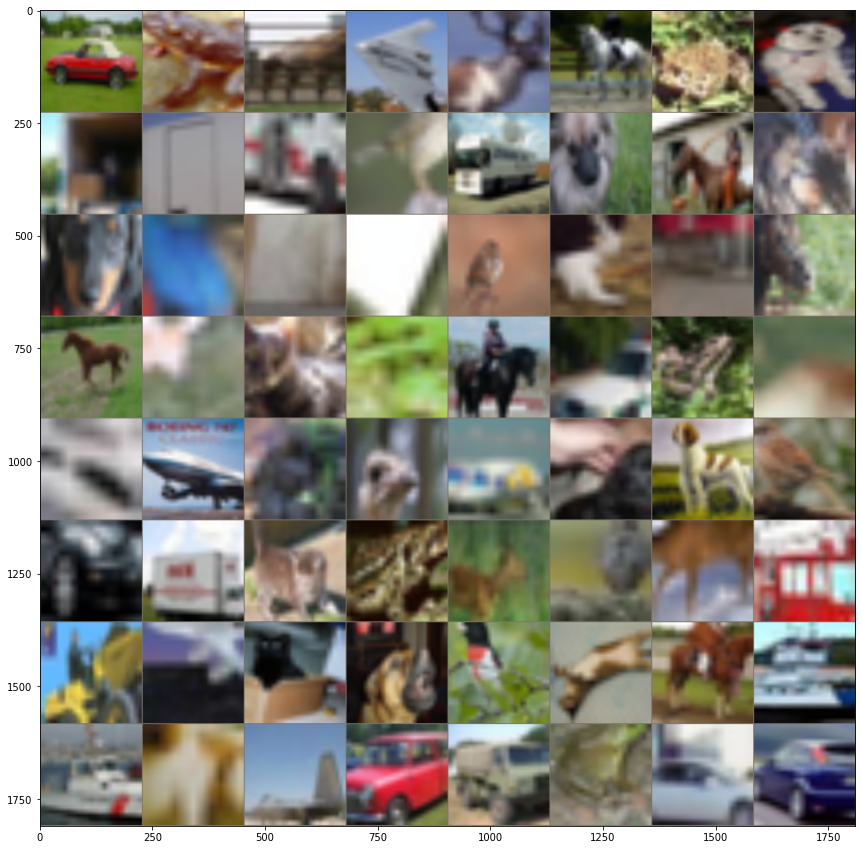

In [3]:
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(image_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(15, 15))
imshow(out, ax=ax)

In [0]:
# Building TensorBoard to display the Loss vs. Epoch and Acc vs. Epoch
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('log2')

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  # Keep track of the best_model and the best validation accuracy
  best_model = copy.deepcopy(model.state_dict())
  best_val = -1

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()  # Set model to evaluation mode
      
      # Keeping track of the loss of one epoch and the number 
      # of correctly labeled images.
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for i, (x, y) in enumerate(image_dataloaders[phase]):
        x, y = x.to(device), y.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # Track history only in the training phase.
        with torch.set_grad_enabled(phase == 'train'):
          scores = model(x)
          loss = criterion(scores, y)
          _, preds = scores.max(1)
          
          # Backward pass -- Only in the training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss * x.size(0)
        running_corrects += (preds == y).sum()

      # If training, activate the learning rate scheduler
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(data_size[phase])
      epoch_acc = running_corrects.double() / len(data_size[phase])

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
      
      # Writing the epoch info to tensorboard
      writer.add_scalar('Loss/'+phase, epoch_loss, global_step=epoch)
      writer.add_scalar('Acc/'+phase, epoch_acc, global_step=epoch)
      
      if phase == 'val' and epoch_acc > best_val:
        best_val = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    
      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_val))

  # Load the best model parameters
  model.load_state_dict(best_model)
  return model

In [0]:
def visualize_model(model, device, rows=3, cols=3):
  """
  Displays predictions for a few images
  """
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(image_dataloaders['val']):
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size(0)):
        imshow(imgs.data.cpu()[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds.cpu()[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [0]:
# Fine-Tuning All Network
vgg16_ft = torchvision.models.vgg16(pretrained=True, progress=True)
num_features = vgg16_ft.classifier[6].in_features

vgg16_ft.classifier[6] = nn.Linear(num_features, 10) # There are 10 classes in CIFAR10 dataset
criterion = nn.CrossEntropyLoss()

# Using GPU
vgg16_ft = vgg16_ft.to(device)

# A low learning rate is used for finetuning as the pretrained weights shouldn't
# be changed drastically. Also the whole network is being finetuned as all parameters 
# of the network are passed to the optimizer object.
optimizer_ft = optim.SGD(vgg16_ft.parameters(), lr=1e-3, momentum=0.9) 

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

new_model_ft = train_model(vgg16_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 0.9654 Acc: 0.6578

val Loss: 0.4186 Acc: 0.8590

Epoch 1/9
----------
train Loss: 0.7507 Acc: 0.7366

val Loss: 0.3554 Acc: 0.8690

Epoch 2/9
----------
train Loss: 0.6817 Acc: 0.7624

val Loss: 0.3006 Acc: 0.8980

Epoch 3/9
----------
train Loss: 0.6453 Acc: 0.7752

val Loss: 0.3131 Acc: 0.8890

Epoch 4/9
----------
train Loss: 0.6145 Acc: 0.7868

val Loss: 0.2652 Acc: 0.9130

Epoch 5/9
----------
train Loss: 0.5928 Acc: 0.7929

val Loss: 0.2382 Acc: 0.9220

Epoch 6/9
----------
train Loss: 0.5647 Acc: 0.8026

val Loss: 0.2309 Acc: 0.9220

Epoch 7/9
----------
train Loss: 0.4944 Acc: 0.8284

val Loss: 0.2063 Acc: 0.9320

Epoch 8/9
----------
train Loss: 0.4804 Acc: 0.8329

val Loss: 0.1989 Acc: 0.9320

Epoch 9/9
----------
train Loss: 0.4777 Acc: 0.8335

val Loss: 0.1981 Acc: 0.9350

Training complete in 222m 27s
Best val Acc: 0.935000


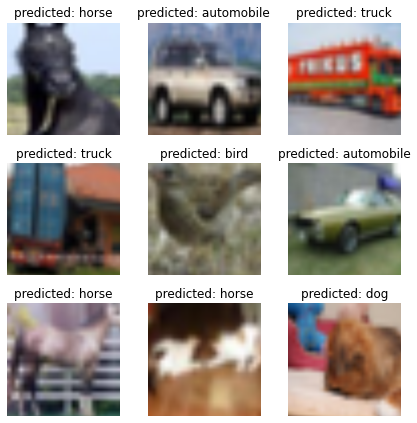

In [0]:
# Visualizing some predictions after fine-tuning on CIFAR10
visualize_model(new_model_ft, device=device)
plt.tight_layout()

In [0]:
writer = SummaryWriter('log3')

In [0]:
# Fine-Tuning Last Two Layers (may be applied to any layer)
vgg16_ft = torchvision.models.vgg16(pretrained=True, progress=True)

# Adding the last linear classifier layer for 10 classes
num_features = vgg16_ft.classifier[6].in_features
vgg16_ft.classifier[6] = nn.Linear(num_features, 10) 

# Freezing the parameters of all layers and unfreezing the ones we want to fine-tune.
# Unfreezing the newly added classifier and the previous two fc layers
for param in vgg16_ft.parameters():
    param.requires_grad = False

for child in vgg16_ft.classifier.children():
  if isinstance(child, nn.Linear):
    for param in child.parameters():
        param.requires_grad = True

# Same set-up as finetuning every weight
vgg16_ft = vgg16_ft.to(device)
optimizer_ft = optim.SGD(vgg16_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) 
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

new_model_ft = train_model(vgg16_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 1.1304 Acc: 0.5944

val Loss: 0.5559 Acc: 0.7950

Epoch 1/9
----------
train Loss: 0.9609 Acc: 0.6564

val Loss: 0.4917 Acc: 0.8170

Epoch 2/9
----------
train Loss: 0.9173 Acc: 0.6706

val Loss: 0.4609 Acc: 0.8340

Epoch 3/9
----------
train Loss: 0.8890 Acc: 0.6829

val Loss: 0.4393 Acc: 0.8420

Epoch 4/9
----------
train Loss: 0.8706 Acc: 0.6895

val Loss: 0.4250 Acc: 0.8440

Epoch 5/9
----------
train Loss: 0.8539 Acc: 0.6958

val Loss: 0.4129 Acc: 0.8490

Epoch 6/9
----------
train Loss: 0.8347 Acc: 0.7032

val Loss: 0.3974 Acc: 0.8560

Epoch 7/9
----------
train Loss: 0.8198 Acc: 0.7093

val Loss: 0.3971 Acc: 0.8520

Epoch 8/9
----------
train Loss: 0.8147 Acc: 0.7099

val Loss: 0.3960 Acc: 0.8540

Epoch 9/9
----------
train Loss: 0.8042 Acc: 0.7126

val Loss: 0.3936 Acc: 0.8560

Training complete in 74m 36s
Best val Acc: 0.856000


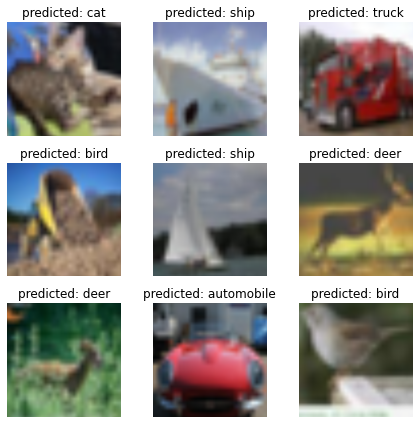

In [0]:
# Visualizing some predictions after fine-tuning on CIFAR10
visualize_model(new_model_ft, device=device)
plt.tight_layout()

In [0]:
writer = SummaryWriter('log4')

In [10]:
# Feature Extractor (CNN Codes)
vgg16_fe = torchvision.models.vgg16(pretrained=True, progress=True)
num_features = vgg16_fe.classifier[6].in_features
vgg16_fe.classifier[6] = nn.Linear(num_features, 10) # There are 10 classes in CIFAR10 dataset

# Using GPU
vgg16_fe = vgg16_fe.to(device)

# Freezing the parameters of all layers to get CNN codes of 4096-D vectors
# And Unfreezing the weight of the newly added classifier.
for param in vgg16_fe.parameters():
    param.requires_grad = False

vgg16_fe.classifier[6].weight.requires_grad = True
vgg16_fe.classifier[6].bias.requires_grad = True

# Same set-up as finetuning section except for the learning rate
# Learning rate can be set to yet again 0.01 because we are training
# only the last linear classifier. 
vgg16_fe = vgg16_fe.to(device)
optimizer_ft = optim.SGD(vgg16_fe.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4) 
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

new_model_ft = train_model(vgg16_fe, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 1.5817 Acc: 0.5354

val Loss: 0.8640 Acc: 0.7210

Epoch 1/9
----------
train Loss: 1.6088 Acc: 0.5500

val Loss: 0.7892 Acc: 0.7690

Epoch 2/9
----------
train Loss: 1.6102 Acc: 0.5553

val Loss: 0.7461 Acc: 0.7730

Epoch 3/9
----------
train Loss: 1.5911 Acc: 0.5601

val Loss: 0.6812 Acc: 0.7880

Epoch 4/9
----------
train Loss: 1.6016 Acc: 0.5616

val Loss: 0.6956 Acc: 0.7800

Epoch 5/9
----------
train Loss: 1.5791 Acc: 0.5649

val Loss: 0.8409 Acc: 0.7380

Epoch 6/9
----------
train Loss: 1.6288 Acc: 0.5592

val Loss: 0.7089 Acc: 0.7710

Epoch 7/9
----------
train Loss: 1.2862 Acc: 0.5994

val Loss: 0.5567 Acc: 0.8150

Epoch 8/9
----------
train Loss: 1.1816 Acc: 0.6091

val Loss: 0.5493 Acc: 0.8100

Epoch 9/9
----------
train Loss: 1.1315 Acc: 0.6187

val Loss: 0.5167 Acc: 0.8270

Training complete in 69m 33s
Best val Acc: 0.827000


In [11]:
%load_ext tensorboard
%tensorboard --logdir log4

Output hidden; open in https://colab.research.google.com to view.

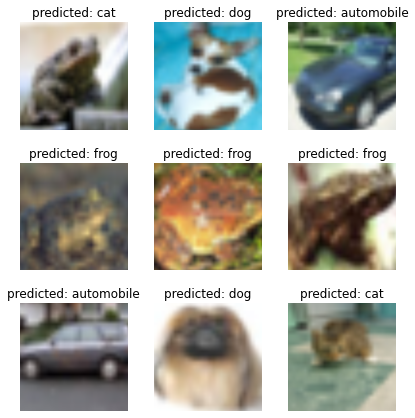

In [12]:
# Visualizing some predictions after transfer learning on CIFAR10
visualize_model(new_model_ft, device=device)
plt.tight_layout()